In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

In [ ]:
%matplotlib inline

# Attributed graphs in NetworkX

In [5]:
import networkx as nx
import igraph as ig
import numpy as np
import glob
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns; sns.set_style('white')
import sys; sys.path.append('../')
from time import time
import logging
from anytree import LevelOrderIter
from statistics import mean
import os

In [6]:
from VRG.src.utils import load_pickle, nx_to_igraph, check_file_exists
from VRG.src.graph_stats import GraphStats
from VRG.src.graph_comparison import GraphPairCompare
from VRG.runner import get_clustering
from VRG.src.Tree import create_tree, dasgupta_cost
from VRG.src.MDL import graph_dl as graph_mdl

sys path:  ['/home/jupyter-ssikdar/Attributed-VRG/notebooks', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python37.zip', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/lib-dynload', '', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages', '/home/jupyter-ssikdar/miniconda3/envs/VRG/lib/python3.7/site-packages/IPython/extensions', '/home/jupyter-ssikdar/.ipython', '../', './../', './../../']


In [3]:
def get_graph(gname: str = 'sample'):
    start_time = time()
    attr_name = ''
    if gname == 'sample':
        g = nx.Graph()
        g.add_nodes_from(range(5), color='blue')
        g.add_nodes_from(range(5, 9), color='red')

        g.add_edges_from([(0, 1), (0, 3), (0, 4),
                          (1, 2), (1, 4), (1, 5),
                          (2, 3), (2, 4), (2, 8),
                          (3, 4),
                          (5, 6), (5, 7), (5, 8),
                          (6, 7), (6, 8),
                          (7, 8)])  # properly labeled
        g.name = 'sample'
        attr_name = 'color'
    elif gname == 'karate':
        g = nx.karate_club_graph()
        attr_name = 'club'
        g.name = 'karate'
    elif gname == 'BA':
        g = nx.barabasi_albert_graph(10, 2, seed=42)
        # g = nx.MultiGraph(g)
        g = nx.Graph()
    elif gname.endswith('.gpickle'):
        g = nx.read_gpickle(gname)
        g.name = Path(gname).stem
    else:
        if gname in ('waterloo', 'grenoble', 'uppsala'):
            g = nx.read_gpickle(f'../snap_data/cleaned/{gname}_lcc_attr.gpickle')
        elif gname in ('polblogs', 'polbooks', 'football', 'bipartite-10-10'):
            g = nx.read_gml(f'../VRG/input/{gname}.gml')
            attr_name = 'value'
        else:
            path = f'../VRG/input/{gname}.g'
            g = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

        g.remove_edges_from(nx.selfloop_edges(g))
        if not nx.is_connected(g):
            nodes_lcc = max(nx.connected_components(g), key=len)
            g = g.subgraph(nodes_lcc).copy()
        name = g.name
        g = nx.convert_node_labels_to_integers(g, label_attribute='orig_label')
        g.name = name

    end_time = round(time() - start_time, 2)
    logging.error(f'Graph: {gname}, n = {g.order():_d}, m = {g.size():_d}, read in {round(end_time, 3):_g}s.')

    return g, attr_name

In [4]:
def get_clustering(g: nx.Graph, outdir: str, clustering: str, use_pickle: bool, max_size=None):
    """
    wrapper method for getting dendrogram. uses an existing pickle if it can.
    :param g: graph
    :param outdir: output directory where picles are stored
    :param clustering: name of clustering method
    :param use_pickle: flag to whether or not to use the pickle
    :return: root node of the dendrogram
    """
    if g.name == 'sample':
        list_of_list_clusters = [
            [
                [[0], [1]],
                [[2], [[3], [4]]]
            ],
            [
                [[5], [6]],
                [[7], [8]]
            ]
        ]
        return list_of_list_clusters

    list_of_list_filename = os.path.join(outdir, f'{clustering}_list.pkl')

    if not os.path.exists(f'./{outdir}'):
        os.makedirs(f'./{outdir}')

    if check_file_exists(list_of_list_filename) and use_pickle:
        logging.error(f'Using existing pickle for {clustering!r} clustering\n')
        list_of_list_clusters = load_pickle(list_of_list_filename)

    else:
        tqdm.write(f'Running {clustering!r} clustering...')
        if clustering == 'random':
            list_of_list_clusters = partitions.get_random_partition(g)
        elif clustering == 'consensus':
            # delete the matlab tree and sc files
            matlab_files_path = './src/matlab_clustering/HierarchicalConsensus/data'
            tree_path = os.path.join(matlab_files_path, f'{g.name}_tree.mat')
            sc_path = os.path.join(matlab_files_path, f'{g.name}_sc.vec')
            if check_file_exists(tree_path):
                os.remove(tree_path)
            if check_file_exists(sc_path):
                os.remove(sc_path)
            list_of_list_clusters = get_consensus_root(g=g, gname=g.name)
        elif clustering in ('leiden', 'louvain', 'infomap', 'labelprop'):
            if max_size is None: max_size = g.order()
            list_of_list_clusters = partitions.louvain_leiden_infomap_label_prop(g, method=clustering, max_size=max_size)
        elif clustering == 'cond':
            list_of_list_clusters = partitions.approx_min_conductance_partitioning(g)
        elif clustering == 'spectral':
            list_of_list_clusters = partitions.spectral_kmeans(g, K=int(math.sqrt(g.order() // 2)))
        else:
            raise NotImplementedError(f'Invalid clustering algorithm {clustering!r}')
        dump_pickle(list_of_list_clusters, list_of_list_filename)

    return list_of_list_clusters

In [5]:
def plot_graph(g, ax=None, title='', attr_name='', mixing_dict={}):
    if attr_name != '' and len(mixing_dict) == 0:
        mixing_dict = nx.attribute_mixing_dict(g, attr_name)
        
    unique_values = set(mixing_dict.keys())
    colors = sns.color_palette('pastel', n_colors=len(unique_values))
    color_map = {val: col for val, col in zip(unique_values, colors)}

    try:
        colors = [color_map[d[attr_name]] for _, d in g.nodes(data=True)]
    except KeyError:
        colors = '#77dd77'
    pos = nx.spring_layout(g)

    if ax is not None:
        ax.set_title(title, fontsize=20)
    nx.draw_networkx_nodes(g, pos=pos, node_size=100, node_color=colors, alpha=0.95, ax=ax)
    nx.draw_networkx_edges(g, pos=pos, edge_color='gray', alpha=0.7, ax=ax)
    return

In [6]:
def grid_plot(graphs, graph_name='', attr_name='', mixing_dict={}):
    # todo keep the positions of the constant nodes fixed
    rows, cols = 2, 4
    plt.rcParams['figure.figsize'] = [30, 15]

    grid = gridspec.GridSpec(rows, cols)
    fig = plt.figure()
    for i, box in enumerate(grid):
        ax = fig.add_subplot(box)
        g = graphs[i]
        deg_as = round(nx.degree_assortativity_coefficient(g), 3)
        attr_as = round(nx.attribute_assortativity_coefficient(g, attribute=attr_name), 3)
        title = f'g{i + 1} {g.order(), g.size()} degree as: {deg_as} {attr_name} as: {attr_as}'
        plot_graph(g, ax=ax, title=title, mixing_dict=mixing_dict, attr_name=attr_name)

    plt.tight_layout()
    plt.suptitle(f'{graph_name}', y=1, fontsize=25)

In [7]:
def get_tree_stats(g, root):
    """
    Compute height of the tree, avg branching factor, dasgupta cost
    """
    ht = root.height
    avg_branch_factor = mean(len(node.children) for node in LevelOrderIter(root) if len(node.children) > 1)
    dc = dasgupta_cost(g, root)
    return ht, avg_branch_factor, dc

In [8]:
def make_graph_df(name, fname, orig_graph, mu, clustering, attr_name):
    deg_ast_fn = nx.degree_assortativity_coefficient
    attr_ast_fn = nx.attribute_assortativity_coefficient
    
    gen_graphs = load_pickle(fname)
    
    cols = ['name', 'orig_n', 'orig_m', 'orig_degree_ast', 'attr_name', 'orig_attr_ast', 
            'model', 'mu', 'clustering', 'gen_n', 'gen_m', 'gen_degree_ast', 'gen_attr_ast', 
            'total_rewired_edges', 'fancy_rewired_edges',
            'degree_js', 'pagerank_js', 'lambda_dist', 'deg_ast_diff', 'attr_ast_diff']
    
    row = {col: np.nan for col in cols}
    
    orig_deg_ast = deg_ast_fn(orig_graph)
    orig_attr_ast = attr_ast_fn(orig_graph, attr_name)
    orig_gstats = GraphStats(orig_graph)
    rows = []
    
    for g in gen_graphs:
        gen_gstats = GraphStats(g)
        gpc = GraphPairCompare(orig_gstats, gen_gstats)
        gen_deg_ast = deg_ast_fn(g)
        gen_attr_ast = attr_ast_fn(g, attr_name)
        total_rewired_edges = g.graph.get('total_rewirings', 0)
        fancy_rewired_edges = g.graph.get('fancy_rewirings', 0)
        
        row = {'name': name, 'orig_n': orig_graph.order(), 'orig_m': orig_graph.size(), 
               'orig_degree_ast': deg_ast_fn(orig_graph), 'attr_name': attr_name, 
               'orig_attr_ast': attr_ast_fn(orig_graph, attr_name), 'model': grammar_type, 
               'clustering': clustering, 'mu': mu,
               'gen_n': g.order(), 'gen_m': g.size(), 'gen_degree_ast': gen_deg_ast, 'gen_attr_ast': gen_attr_ast, 
               'total_rewired_edges': total_rewired_edges, 'fancy_rewired_edges': fancy_rewired_edges,
               'degree_js': gpc.degree_js(), 'pagerank_js': gpc.pagerank_js(), 'lambda_dist': gpc.lambda_dist(), 
               'deg_ast_diff': np.abs(orig_deg_ast - gen_deg_ast), 'attr_ast_diff': np.abs(orig_attr_ast - gen_attr_ast),
              }
        
        rows.append(row)
    
    return pd.DataFrame(rows)

In [43]:
def make_grammar_df():
    names = ['karate', 'football', 'polbooks', 'polblogs', 'eucore', 'flights', 'chess']
    rows = []

    root_dict = {name: {} for name in names}
    dl_dict = {}
    
    for name in names:
        orig_graph, attr_name = get_graph(name)
        dl_dict[name] = graph_mdl(orig_graph)
        if attr_name != '':
            dl_dict[f'{name}-attr'] = graph_mdl(orig_graph, attributed=True)
    print(dl_dict)
    
    for name in names:
        orig_graph, attr_name = get_graph(name)        
        print('\n\n', name)
        for fname in glob.glob(f'../VRG/dumps/grammars/{name}/*.pkl'):
            path = Path(fname)
            pattern = r'(.*)\_(\w+)\_(\d+)\_(\d+)'
            m = re.match(pattern, path.stem)
            grammar_type, clustering, mu, _ = m.groups()
            
            print(grammar_type, clustering, mu, end='\t', flush=True)
            
            if clustering in root_dict[name]:
                ht, avg_branch_factor, dc = root_dict[name][clustering]
            else:
                root = load_pickle(f'../VRG/dumps/trees/{name}/{clustering}_list.pkl')
                if isinstance(root, list): root = create_tree(root)
                ht, avg_branch_factor, dc = get_tree_stats(g=orig_graph, root=root)
                root_dict[name][clustering] = ht, avg_branch_factor, dc

            vrg = load_pickle(fname)
            if grammar_type.startswith('AVRG'): name = f'{name}-attr'
            graph_dl = dl_dict[name]
            
            row = dict(name=name, orig_n=orig_graph.order(), orig_m=orig_graph.size(), attr_name=attr_name, 
                      model=grammar_type, mu=int(mu), clustering=clustering, cost=dc, branch_factor=avg_branch_factor,
                      height=ht, graph_dl=graph_dl, num_rules=vrg.num_rules, unique_rules=len(vrg.unique_rule_list),
                      grammar_dl=vrg.cost)
            name = name.replace('-attr', '')
            rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
%%time
grammar_df = make_grammar_df()

Graph: karate, n = 34, m = 78, read in 0s.
Graph: football, n = 115, m = 613, read in 0.04s.
Graph: polbooks, n = 105, m = 441, read in 0.03s.
Graph: polblogs, n = 1_222, m = 16_714, read in 1.07s.
Graph: eucore, n = 986, m = 16_064, read in 0.22s.
Graph: flights, n = 2_905, m = 15_645, read in 0.37s.
Graph: chess, n = 7_115, m = 55_779, read in 0.82s.
Graph: karate, n = 34, m = 78, read in 0s.


{'karate': 1513.3728650601124, 'karate-attr': 3015.3728650601124, 'football': 15808.105233314634, 'football-attr': 60141.85416244832, 'polbooks': 12909.498880363222, 'polbooks-attr': 29954.439735840868, 'polblogs': 1561386.2837979903, 'polblogs-attr': 8856733.660589287, 'eucore': 1037461.9169873904, 'flights': 8504535.437736487, 'chess': 50853484.56408249}


 karate
AVRG-all-tnodes leiden 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	AVRG-mu-random spectral 9	VRG-all-tnodes cond 3	AVRG-mu-random leiden 10	VRG-mu-random labelprop 4	AVRG-mu-random infomap 3	AVRG-mu-random spectral 10	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	AVRG-mu-random labelprop 4	VRG-mu-random spectral 9	VRG-mu-random leiden 10	AVRG-mu-random cond 7	AVRG-all-tnodes louvain 3	AVRG-mu-random labelprop 6	VRG-mu-random louvain 5	AVRG-mu-random consensus 10	AVRG-mu-random louvain 3	AVRG-mu-random infomap 7	VRG-mu-random leiden 7	VRG-mu-random cond 3	AVRG-mu-rand

Graph: football, n = 115, m = 613, read in 0.05s.




 football
AVRG-all-tnodes leiden 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	AVRG-mu-random spectral 9	VRG-all-tnodes cond 3	AVRG-mu-random leiden 10	VRG-mu-random labelprop 4	AVRG-mu-random infomap 3	AVRG-mu-random spectral 10	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	AVRG-mu-random labelprop 4	VRG-mu-random spectral 9	VRG-mu-random leiden 10	AVRG-mu-random cond 7	AVRG-all-tnodes louvain 3	AVRG-mu-random labelprop 6	VRG-mu-random louvain 5	AVRG-mu-random consensus 10	AVRG-mu-random louvain 3	AVRG-mu-random infomap 7	VRG-mu-random leiden 7	VRG-mu-random cond 3	AVRG-mu-random cond 5	AVRG-mu-random cond 5	VRG-mu-random cond 3	AVRG-mu-random louvain 3	AVRG-mu-random consensus 10	VRG-mu-random louvain 5	AVRG-mu-random labelprop 6	AVRG-mu-random louvain 10	VRG-mu-random consensus 8	AVRG-mu-random cond 7	VRG-mu-random spectral 9	AVRG-mu-random labelprop 4	VRG-mu-random louvain 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	AVR

Graph: polbooks, n = 105, m = 441, read in 0.03s.




 polbooks
AVRG-all-tnodes leiden 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	AVRG-mu-random spectral 9	VRG-all-tnodes cond 3	AVRG-mu-random leiden 10	VRG-mu-random labelprop 4	AVRG-mu-random infomap 3	AVRG-mu-random spectral 10	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	AVRG-mu-random labelprop 4	VRG-mu-random spectral 9	VRG-mu-random leiden 10	AVRG-mu-random cond 7	AVRG-all-tnodes louvain 3	AVRG-mu-random labelprop 6	VRG-mu-random louvain 5	AVRG-mu-random consensus 10	AVRG-mu-random louvain 3	AVRG-mu-random infomap 7	VRG-mu-random leiden 7	VRG-mu-random cond 3	AVRG-mu-random cond 5	AVRG-mu-random cond 5	VRG-mu-random cond 3	AVRG-mu-random louvain 3	AVRG-mu-random consensus 10	VRG-mu-random louvain 5	AVRG-mu-random labelprop 6	AVRG-mu-random louvain 10	VRG-mu-random consensus 8	AVRG-mu-random cond 7	VRG-mu-random spectral 9	AVRG-mu-random labelprop 4	VRG-mu-random louvain 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	AVR

Graph: polblogs, n = 1_222, m = 16_714, read in 1.03s.




 polblogs
VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random leiden 10	VRG-mu-random louvain 5	VRG-mu-random leiden 7	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-mu-random louvain 5	VRG-mu-random spectral 9	VRG-mu-random louvain 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random labelprop 4	VRG-all-tnodes cond 3	VRG-mu-random cond 5	VRG-mu-random infomap 7	VRG-all-tnodes louvain 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 3	VRG-mu-random labelprop 6	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random cond 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random louvain 5	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-all-tnodes leiden 3	VRG-mu-random louvain 5	VRG-mu-random spectral 9	VRG-mu-random 

Graph: eucore, n = 986, m = 16_064, read in 0.22s.




 eucore
VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random leiden 10	VRG-mu-random louvain 5	VRG-mu-random leiden 7	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-mu-random louvain 5	VRG-mu-random consensus 8	VRG-mu-random spectral 9	VRG-mu-random louvain 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random labelprop 4	VRG-all-tnodes cond 3	VRG-mu-random cond 5	VRG-mu-random infomap 7	VRG-all-tnodes louvain 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 3	VRG-mu-random labelprop 6	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random cond 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random louvain 5	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-all-tnodes leiden 3	VRG-mu-random louvain 5	VRG-mu-random s

Graph: flights, n = 2_905, m = 15_645, read in 0.26s.




 flights
VRG-mu-random labelprop 6	VRG-mu-random louvain 10	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random infomap 5	VRG-mu-random leiden 3	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random leiden 10	VRG-mu-random louvain 5	VRG-mu-random leiden 7	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-mu-random louvain 5	VRG-mu-random consensus 8	VRG-mu-random spectral 9	VRG-mu-random louvain 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random labelprop 4	VRG-all-tnodes cond 3	VRG-mu-random cond 5	VRG-mu-random infomap 7	VRG-all-tnodes louvain 3	VRG-mu-random labelprop 6	VRG-mu-random louvain 3	VRG-mu-random labelprop 6	VRG-mu-random infomap 7	VRG-all-tnodes cond 3	VRG-mu-random labelprop 4	VRG-mu-random cond 7	VRG-mu-random leiden 3	VRG-mu-random infomap 5	VRG-mu-random louvain 7	VRG-mu-random spectral 9	VRG-mu-random louvain 5	VRG-mu-random cond 3	VRG-mu-random cond 3	VRG-all-tnodes leiden 3	VRG-mu-random louvain 5	VRG-mu-random 

Graph: chess, n = 7_115, m = 55_779, read in 0.95s.




 chess
VRG-mu-random labelprop 6	VRG-mu-random louvain 10	

Process ForkPoolWorker-1888:
Process ForkPoolWorker-1885:
Process ForkPoolWorker-1886:
Process ForkPoolWorker-1889:
Process ForkPoolWorker-1882:
Process ForkPoolWorker-1884:
Process ForkPoolWorker-1881:
Process ForkPoolWorker-1887:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/satyaki/miniconda3/envs/VRG/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
   

In [ ]:
grammar_df.head()

In [ ]:
grammar_df.name.unique()

In [ ]:
grammar_df['compression'] = grammar_df['graph_dl'] / grammar_df['grammar_dl']

In [ ]:
grammar_df.to_csv('grammar_df.csv', index=False)

In [19]:
grammar_df.model.unique()

array(['AVRG-all-tnodes', 'VRG-mu-random', 'AVRG-mu-random',
       'VRG-all-tnodes'], dtype=object)

In [20]:
plt.rcParams['figure.figsize'] = (15, 10)

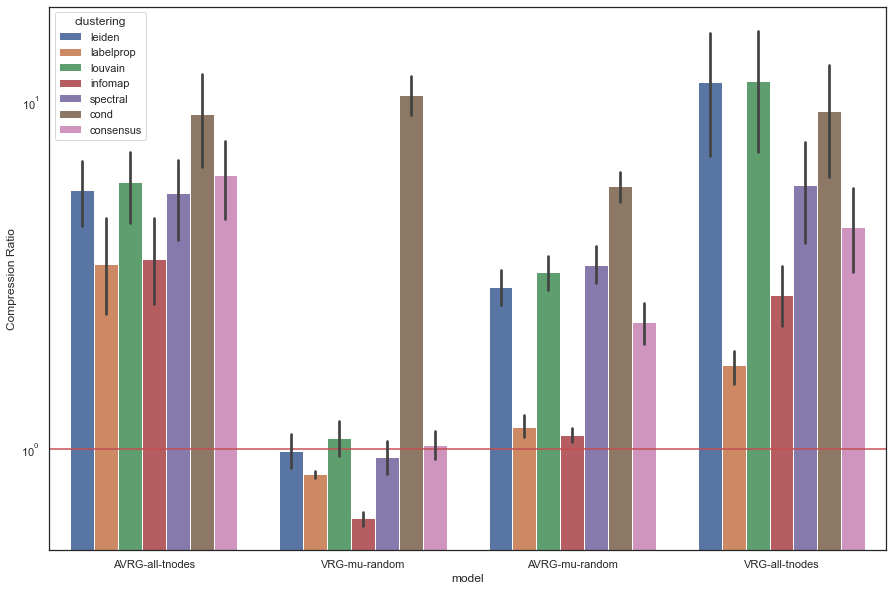

In [42]:
ax = plt.gca()
ax.set_yscale('log')
ax.axhline(1, c='r')
sns.barplot(x='model', y='compression', hue='clustering', data=grammar_df);
ax.set_ylabel('Compression Ratio');

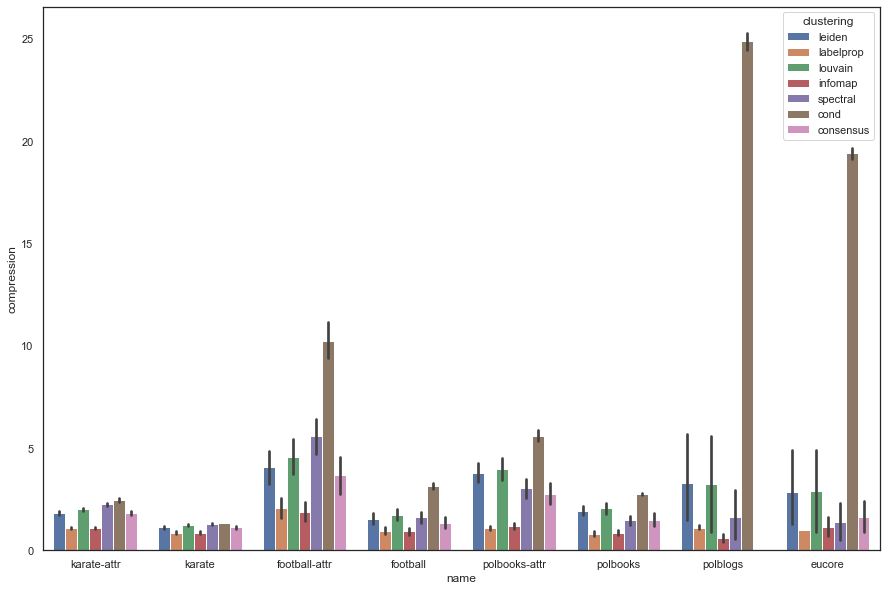

In [41]:
sns.barplot(x='name', y='compression', hue='clustering', data=grammar_df);

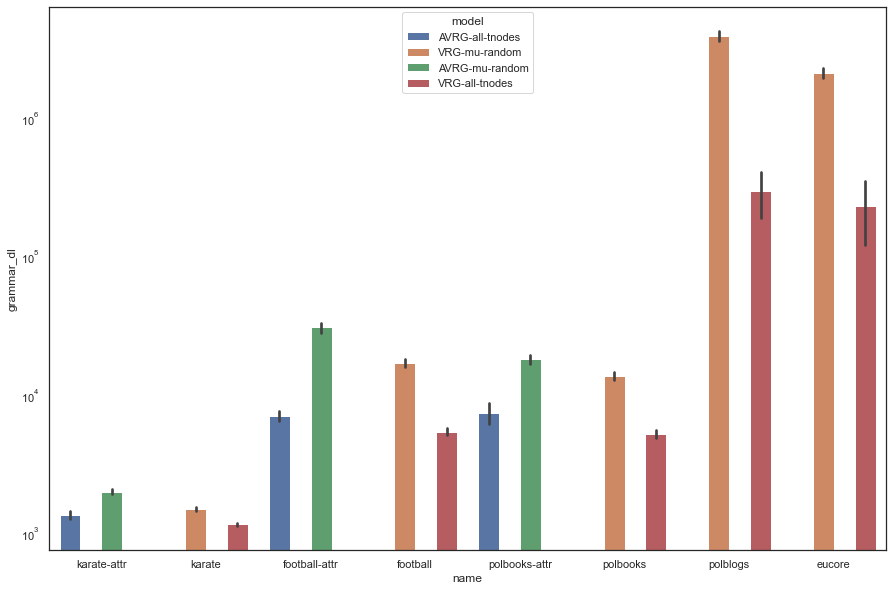

In [22]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='grammar_dl', hue='model', data=grammar_df);
# ax.set_ylabel('Compression Ratio');

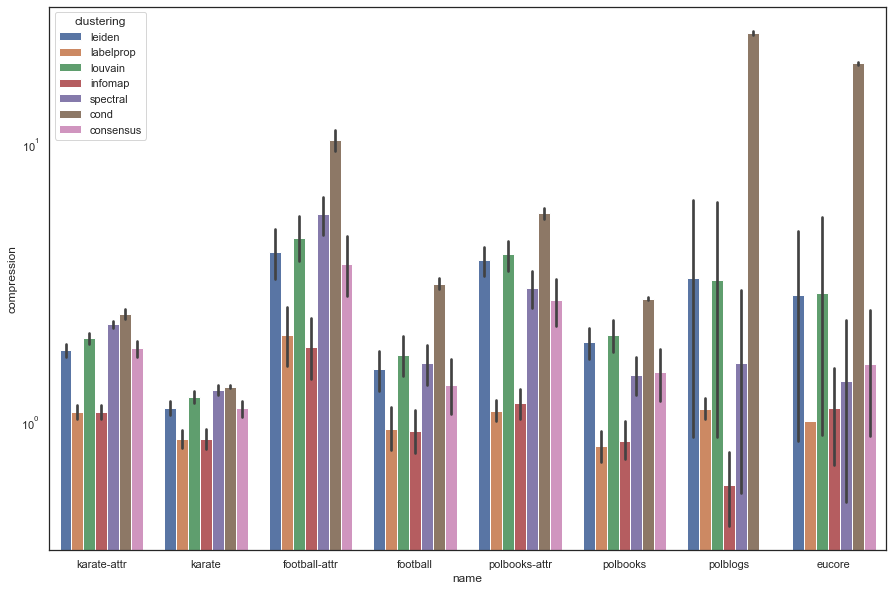

In [23]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='compression', hue='clustering', data=grammar_df);
# ax.set_ylabel('Compression Ratio');

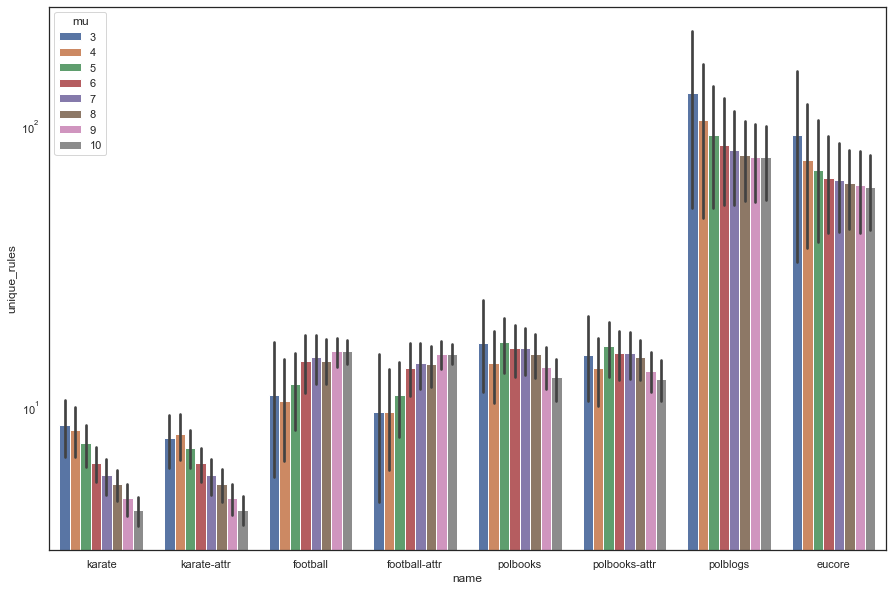

In [24]:
ax = plt.gca()
ax.set_yscale('log')
# ax.axhline(1, c='r')
sns.barplot(x='name', y='unique_rules', hue='mu', data=grammar_df[~grammar_df.model.str.contains('all-tnodes')]);
# ax.set_ylabel('Compression Ratio');

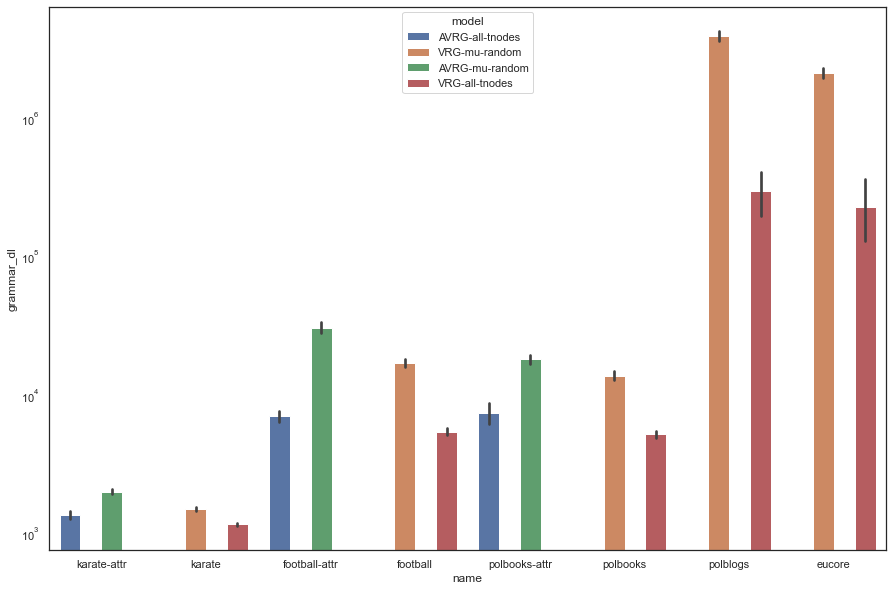

In [25]:
ax = plt.gca()
ax.set_yscale('log')
sns.barplot(x='name', y='grammar_dl', hue='model', data=grammar_df);

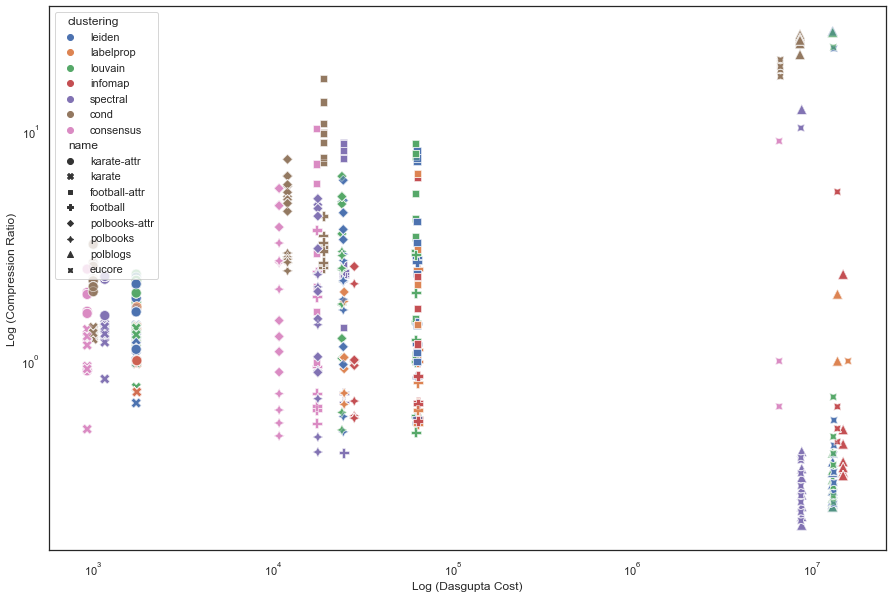

In [26]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='cost', y='compression', hue='clustering', style='name', data=grammar_df,
               s=100, alpha=0.6);
ax.set_xlabel('Log (Dasgupta Cost)');
ax.set_ylabel('Log (Compression Ratio)');

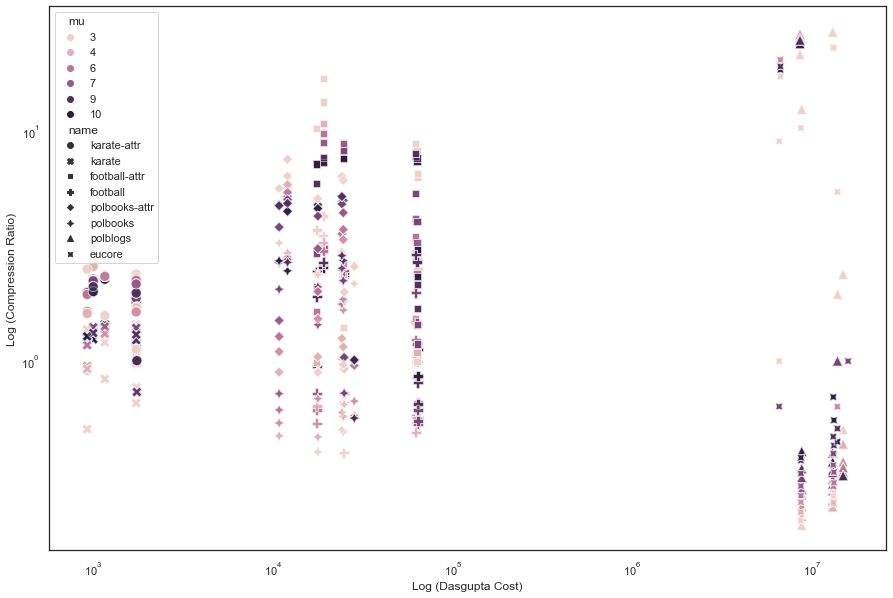

In [27]:
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
sns.scatterplot(x='cost', y='compression', hue='mu', style='name', data=grammar_df,
               s=100, alpha=0.6);
ax.set_xlabel('Log (Dasgupta Cost)');
ax.set_ylabel('Log (Compression Ratio)');

In [ ]:
grammar_df['log_compression'] = grammar_df['compression'].apply(np.log10)

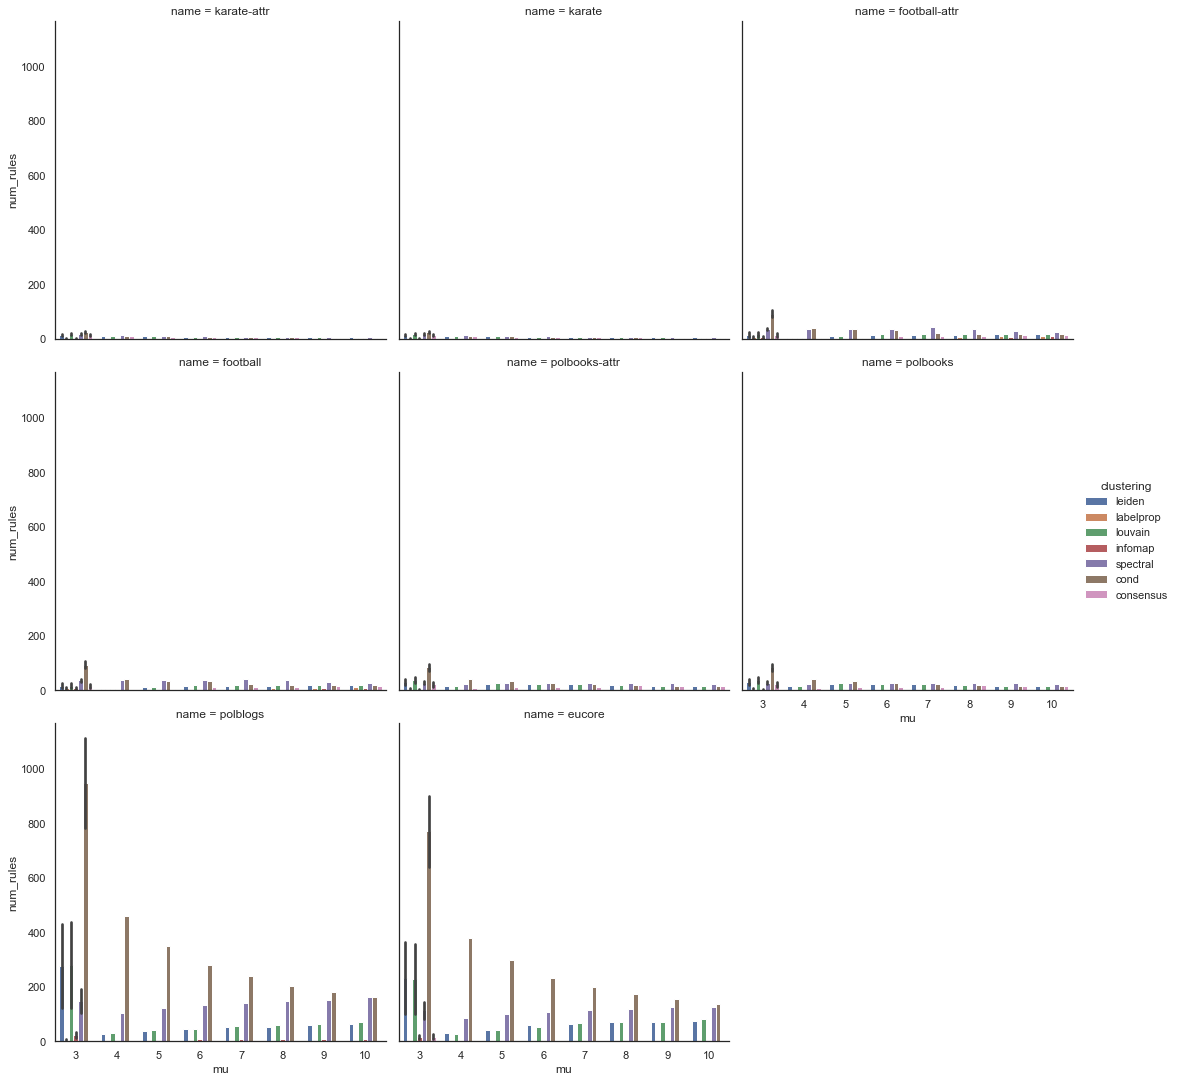

In [28]:
sns.catplot(x='mu', y='num_rules', hue='clustering', col='name', kind='bar', data=grammar_df, col_wrap=3);

In [ ]:
%%time
names = ['karate', 'football', 'polbooks', 'polblogs']
attr_d = {'karate': 'club', 'football': 'value', 'polblogs': 'value', 'polbooks': 'value', 'bipartite-10-10': 'color'}
dfs = []

for name in names:
    attr_name = attr_d[name]
    orig_graph = get_graph(name)

    for fname in glob.glob(f'../VRG/dumps/graphs/{name}/*.pkl'):
        path = Path(fname)
        pattern = r'(.*)\_(\w+)\_(\d)\_(\d+)'
        m = re.match(pattern, path.stem)
        grammar_type, clustering, mu, _ = m.groups()
        df = make_graph_df(name=name, fname=path, orig_graph=orig_graph, mu=int(mu), clustering=clustering, attr_name=attr_name)
        dfs.append(df)
    
overall_df = pd.concat(dfs, ignore_index=True)

In [ ]:
overall_df

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)

ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax3.set_ylim((-0.1, 4.5))

sns.boxplot(x='name', y='degree_js', hue='model', data=overall_df, ax=ax1);
sns.boxplot(x='name', y='pagerank_js', hue='model', data=overall_df, ax=ax2);
sns.boxplot(x='name', y='lambda_dist', hue='model', data=overall_df, ax=ax3);

In [ ]:
plt.rcParams['figure.figsize'] = [15, 6]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.set_ylim((-0.1, 1))
ax2.set_ylim((-0.1, 1))

sns.boxplot(x='name', y='deg_ast_diff', hue='model', data=overall_df, ax=ax1);
sns.boxplot(x='name', y='attr_ast_diff', hue='model', data=overall_df, ax=ax2);
ax2.legend().set_visible(False);

----

In [ ]:
# name = 'karate'; attr_name = 'club'
name = 'polbooks'; attr_name = 'value'
orig_g = get_graph(name)

mixing_dict = nx.attribute_mixing_dict(orig_g, attr_name)

In [ ]:
graphs = load_pickle(f'../VRG/dumps/graphs/polbooks/A-VRG-regular_leiden_5_20.pkl')

In [ ]:
graphs_to_draw = [orig_g] + graphs[: 7]

In [ ]:
grid_plot(graphs_to_draw, attr_name=attr_name, mixing_dict=mixing_dict, graph_name=name)

--- 
Try out football and polblogs

In [ ]:
g = nx.read_pajek('../VRG/input/Epa.net')
g = nx.Graph(g)

In [ ]:
g.remove_edges_from(nx.selfloop_edges(g))
print(nx.info(g))

In [ ]:
# make a bipartite graph
for seed in range(10):
    g = nx.bipartite.random_graph(5, 5, 0.6, seed=seed)
    if nx.is_connected(g):
        print('seed', seed)
        break

In [ ]:
ig_g = ig.Graph.Random_Bipartite(5, 5, 0.6)
ig.plot(ig_g, layout=ig_g.layout_bipartite())

In [ ]:
part = ig_g.community_optimal_modularity()
print(part)

In [ ]:
ig.plot(part, layout=ig_g.layout_bipartite())

In [ ]:
ig.plot(part

### do some things with bipartite graphs

In [ ]:
bip_df = overall_df[overall_df.name.str.contains('bipartite')]

In [ ]:
bip_df.is_bipartite.value_counts()

In [ ]:
nx.algorithms.coloring.

Cora

In [1]:
! head ../VRG/input/cora/cora/cora.cites

35	1033
35	103482
35	103515
35	1050679
35	1103960
35	1103985
35	1109199
35	1112911
35	1113438
35	1113831


In [2]:
! head ../VRG/input/cora/cora/cora.content

31336	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

31349	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	

In [3]:
! head ../VRG/input/cora/cora/README

This directory contains the a selection of the Cora dataset (www.research.whizbang.com/data).

The Cora dataset consists of Machine Learning papers. These papers are classified into one of the following seven classes:
		Case_Based
		Genetic_Algorithms
		Neural_Networks
		Probabilistic_Methods
		Reinforcement_Learning
		Rule_Learning
		Theory


In [7]:
nx_g = nx.Graph()

with open('../VRG/input/cora/cora/cora.cites') as fp:
    for line in fp.readlines():
        u, v = map(int, line.split())
        nx_g.add_edge(u, v)

In [8]:
print(nx.info(nx_g))

Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [10]:
values = {}

with open('../VRG/input/cora/cora/cora.content') as fp:
    for line in fp.readlines():
        u, *_, cat = line.split()
        values[int(u)] = cat

In [12]:
len(values)

2708

In [15]:
nx.set_node_attributes(nx_g, name='value', values=values)

In [17]:
nx.write_gml(nx_g, '../VRG/input/cora.gml')